Segmentación de imágenes usando U-Net
===

* *30 min* | Última modificación: Abril 6, 2020.

Basado en https://www.tensorflow.org/tutorials/images/segmentation

## Importación de librerías

In [12]:
import os
import urllib
import numpy as np
import PIL.Image as Image
import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds


tfds.disable_progress_bar()

print(tf.__version__)
print(hub.__version__)

AUTOTUNE = tf.data.experimental.AUTOTUNE

#
# pix2pix model
#
from tensorflow_examples.models.pix2pix import pix2pix

#
# Librerias adicionales para graficación
#
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling


#
# Establece el nivel de reporte en
# pantalla de TensorFlow
#
import logging

logger = tf.get_logger().setLevel(logging.ERROR)

2.1.0
0.8.0


## Carga y configuración del dataset

In [13]:
dataset, info = tfds.load("oxford_iiit_pet:3.*.*", with_info=True)

In [14]:
#
#  Se normaliza al rango 0-1
#  Los pixels en la segmentación están numerados como {1, 2, 3}. Se 
#  substrae la unidad para convertirlos en {0, 1, 2}
#
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

#
#  Normalización y aumento del dataset de entrenamiento mediante
#  rotación aleatoria de la imagen.
#
@tf.function
def load_image_train(datapoint):

    input_image = tf.image.resize(datapoint["image"], (128, 128))
    input_mask = tf.image.resize(datapoint["segmentation_mask"], (128, 128))

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask


#
#  Dataset de prueba
#
def load_image_test(datapoint): 
    #
    #  La diferencia con la función anterior es que aca no se gira
    #  la imagen
    
    input_image = tf.image.resize(datapoint["image"], (128, 128))
    input_mask = tf.image.resize(datapoint["segmentation_mask"], (128, 128))
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

In [15]:
#
#  El dataset ya contiene la partición en entrenamiento y prueba
#
TRAIN_LENGTH = info.splits["train"].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

#
#  Aplica las funciones de carga de datos a los datasets
#  de entrenamiento y validación
#
train = dataset["train"].map(
    load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE
)

test = dataset["test"].map(load_image_test)

#
#  Prepara los datasets para el modelo
#
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

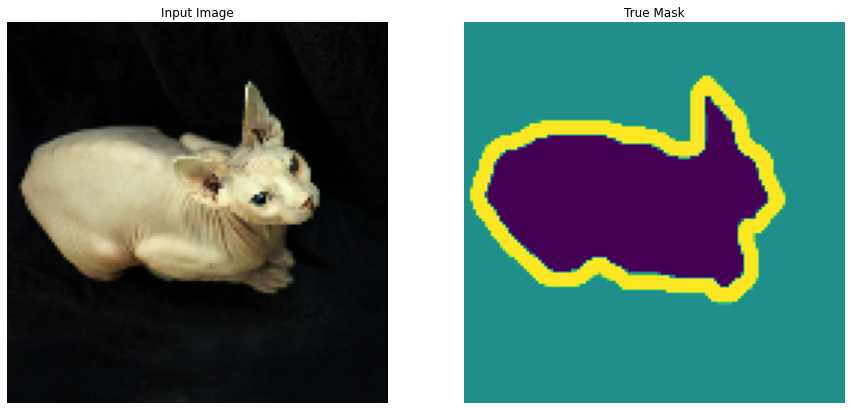

In [16]:
def display(display_list):

    plt.figure(figsize=(15, 15))

    title = ["Input Image", "True Mask", "Predicted Mask"]

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis("off")

    plt.show()


for image, mask in train.take(1):
    sample_image, sample_mask = image, mask

display([sample_image, sample_mask])

## Definición del modelo

In [17]:
OUTPUT_CHANNELS = 3

base_model = tf.keras.applications.MobileNetV2(
    input_shape=[128, 128, 3], include_top=False
)

layer_names = [
    "block_1_expand_relu",  # 64x64
    "block_3_expand_relu",  # 32x32
    "block_6_expand_relu",  # 16x16
    "block_13_expand_relu",  # 8x8
    "block_16_project",  # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

In [18]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),  # 32x32 -> 64x64
]

In [19]:
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])
    x = inputs

    #
    # Downsampling
    #
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    #
    # Upsampling
    #
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])


    last = tf.keras.layers.Conv2DTranspose(
        output_channels, 3, strides=2, padding="same"
    )  # 64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

## Entrenamiento del modelo

In [20]:
model = unet_model(OUTPUT_CHANNELS)

model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [31]:
!pip3 install  pydot graphviz

In [33]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

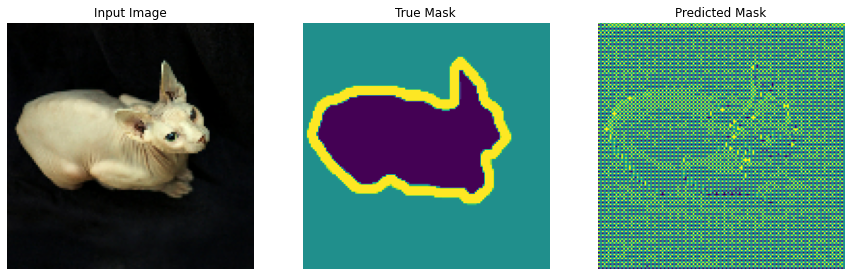

In [34]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display(
            [
                sample_image,
                sample_mask,
                create_mask(model.predict(sample_image[tf.newaxis, ...])),
            ]
        )
        
show_predictions()

In [37]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        show_predictions()
        print("\nSample Prediction after epoch {}\n".format(epoch + 1))

Train for 57 steps, validate for 11 steps
Epoch 1/20
56/57 [============================>.] - ETA: 3s - loss: 0.3037 - accuracy: 0.8754

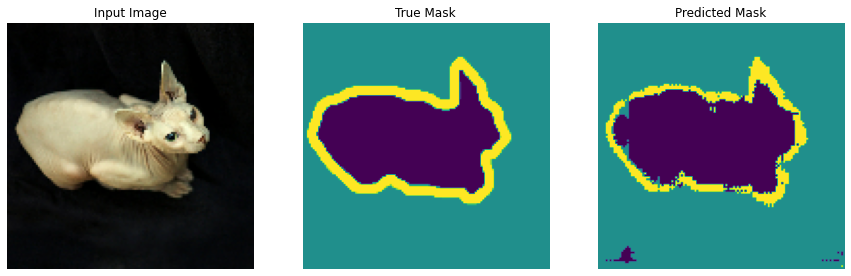


Sample Prediction after epoch 1

57/57 [==============================] - 227s 4s/step - loss: 0.3033 - accuracy: 0.8756 - val_loss: 0.3493 - val_accuracy: 0.8600
Epoch 2/20
56/57 [============================>.] - ETA: 4s - loss: 0.2770 - accuracy: 0.8850

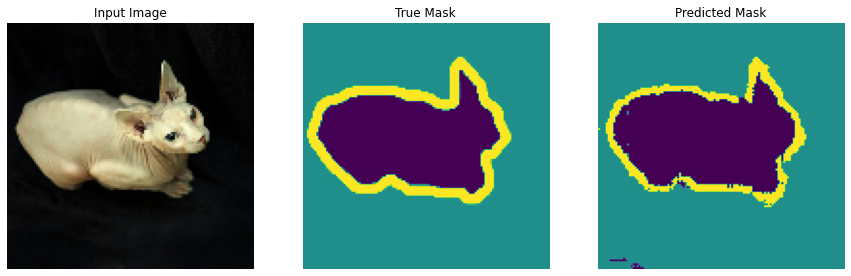


Sample Prediction after epoch 2

57/57 [==============================] - 256s 4s/step - loss: 0.2768 - accuracy: 0.8850 - val_loss: 0.3386 - val_accuracy: 0.8622
Epoch 3/20
56/57 [============================>.] - ETA: 3s - loss: 0.2629 - accuracy: 0.8903

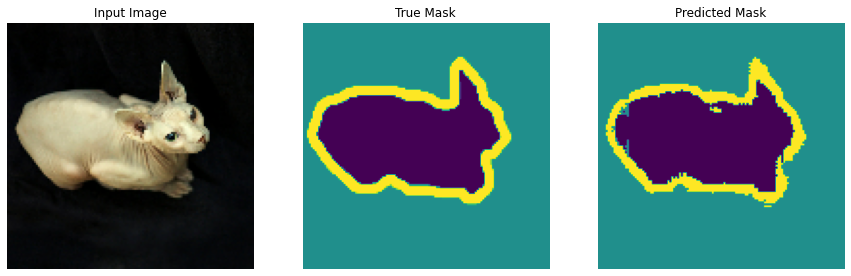


Sample Prediction after epoch 3

57/57 [==============================] - 238s 4s/step - loss: 0.2629 - accuracy: 0.8902 - val_loss: 0.3121 - val_accuracy: 0.8738
Epoch 4/20
56/57 [============================>.] - ETA: 4s - loss: 0.2513 - accuracy: 0.8940

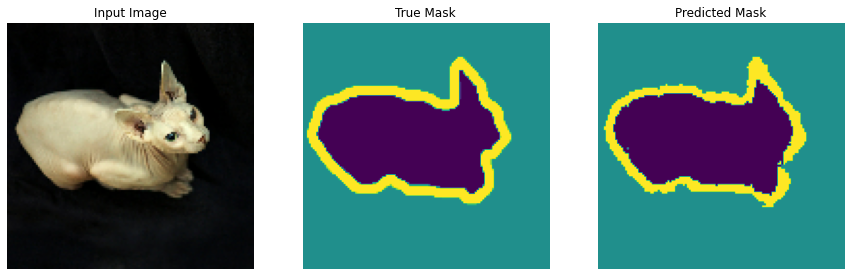


Sample Prediction after epoch 4

57/57 [==============================] - 275s 5s/step - loss: 0.2518 - accuracy: 0.8938 - val_loss: 0.3008 - val_accuracy: 0.8792
Epoch 5/20
 8/57 [===>..........................] - ETA: 3:04 - loss: 0.2518 - accuracy: 0.8944

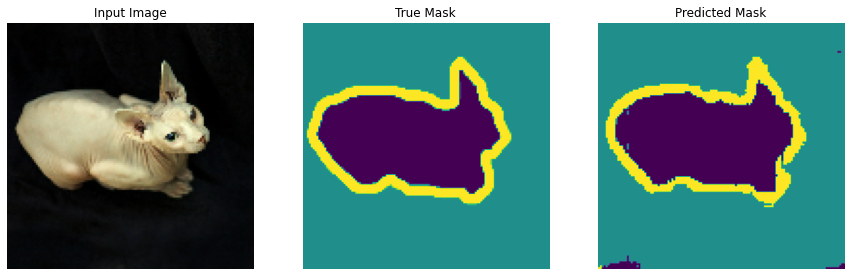


Sample Prediction after epoch 5

 8/57 [===>..........................] - ETA: 3:14 - loss: 0.2518 - accuracy: 0.8944

KeyboardInterrupt: 

In [38]:
EPOCHS = 5
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits["test"].num_examples // BATCH_SIZE // VAL_SUBSPLITS

model_history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    validation_data=test_dataset,
    callbacks=[DisplayCallback()],
)

In [39]:
loss = model_history.history["loss"]
val_loss = model_history.history["val_loss"]

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, "r", label="Training loss")
plt.plot(epochs, val_loss, "bo", label="Validation loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss Value")
plt.ylim([0, 1])
plt.legend()
plt.show()

NameError: name 'model_history' is not defined

## Pronósticos

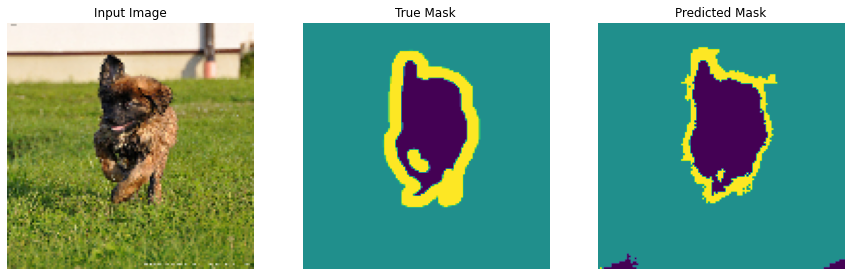

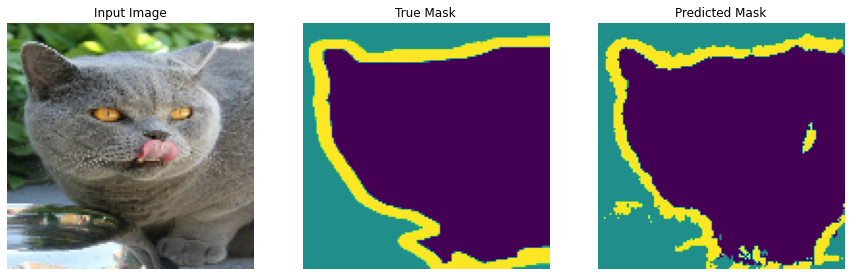

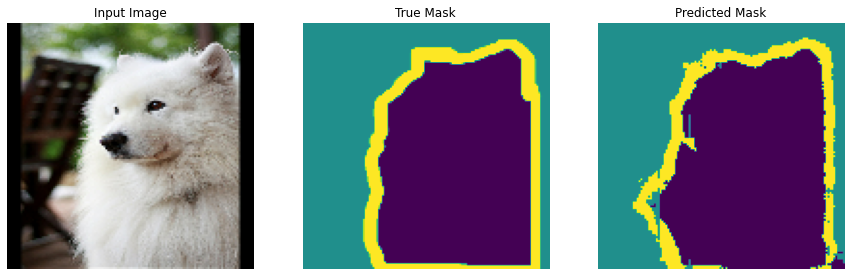

In [40]:
show_predictions(test_dataset, 3)